In [27]:
'''
    Downloading Data
    
    Creating df which includes text data
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string

df = pd.read_csv("regulations.csv")
df['publication_date'] = pd.to_datetime(df['publication_date'])
df_texts = pd.read_csv("regulations_texts.csv", sep=";")
df['text'] = [1 if x in set(df_texts['regulation_project_id']) else 0 for x in df['id']]
df['text_len'] = [len(df_texts[df_texts['regulation_project_id'] == x].iat[0,1]) 
                  if x in set(df_texts['regulation_project_id']) else 0 for x in df['id']]
answers = pd.read_csv("train_answer.csv")



#Get rid of nans
for col in df:
    #get dtype for column
    dt = df[col].dtype 
    #check if it is a number
    if dt == int or dt == float or dt == 'float64':
        df[col] = df[col].fillna(0)
    else:
        df[col] = df[col].fillna("nothing")



df.head()
# len(df)
# df.isnull().sum()
df_texts.head()
len(df_texts)

11384

In [85]:
'''
    Preparing Data
    
    Creating df1 which has only numeric data
'''
        
df1 = df.loc[:,['id', 'publication_date', 'act_title', 'developer', 'okved_list', 'views_num', 
                'dislikes_num', 'regulatory_impact', 
                'is_regionally_signigicant', 'act_changes_controlling_activities', 'mineco_solution',
                'problem_addressed', 'act_objectives', 'persons_affected_by_act',
                'relations_regulated_by_act','act_significance', 'text', 'text_len']]
df1.loc[:,'regulatory_impact'] = [2 if i=="Высокая" else 1 if i=="Средняя" else 0 for i in df1['regulatory_impact']]
df1.loc[:,'mineco_solution'] = [1 if i=="Положительное" else -1 if i=="Отрицательное"
                                else 0 for i in df1['mineco_solution']]
df1.loc[:,['is_regionally_signigicant']] = [1 if i == True else 0 for i in df1['is_regionally_signigicant']]
df1.loc[:,['act_changes_controlling_activities']] = [1 if i == True else 0 
                                                     for i in df1['act_changes_controlling_activities']]
df1.loc[:,['problem_addressed', 'act_objectives', 'persons_affected_by_act', 'relations_regulated_by_act',
           'act_significance']] = df1.loc[:,['problem_addressed', 'act_objectives', 'persons_affected_by_act',
                'relations_regulated_by_act','act_significance']].applymap(lambda x: 0 if x=='nothing' else 1)
df1['okved_list'] = [0 if x=='nothing' else 1 for x in df1['okved_list']]
df1['year'] = [0 if x=='nothing' else x.year for x in df['publication_date']]
df1['month'] = [0 if x=='nothing' else x.month for x in df['publication_date']]
df1['year_end'] = [ min(2021*12 + 9 - df1['year'][i]*12 - df1['month'][i], 12) for i in df1.index]

del df1['month']
#del df1['year']

#Dealing with persons (added_by and responsible)
df1['same_person'] = (df['added_by'] == df['responsible'])
responsible = pd.DataFrame(np.unique(df['responsible'], return_counts=True)).transpose()
responsible = dict(zip(responsible[0], responsible[1]))
responsible['nothing'] = 0
added_by = pd.DataFrame(np.unique(df['added_by'], return_counts=True)).transpose()
added_by = dict(zip(added_by[0], added_by[1]))
added_by['nothing'] = 0
#added_by
df1['responsible_count'] = [responsible[x] for x in df['responsible']]
df1['added_by_count'] = [added_by[x] for x in df['added_by']]


def first_word(table, word):
    '''
        adding feature that the 1st word in act_title is equal to word
    '''
    table[word] = [1 if x.split()[0].strip(string.punctuation).strip('«').lower() == word else 0 
                   for x in table['act_title']]

#first_word(df1, 'федеральный')   
    
A = pd.DataFrame(df['act_title'])
A[0] = [x.split()[0].strip(string.punctuation).strip('«').lower() for x in A['act_title']]
for word in pd.DataFrame(np.unique(A[0], return_counts=True)
                         ).transpose().sort_values(1, ascending=False)[0][:10].values:
    first_word(df1, word)
del df1['act_title']
del df1['publication_date']


#dealing with developers
df1 = pd.get_dummies(df1,columns=["developer"])#, drop_first=True)
df1 = pd.get_dummies(df1,columns=["year"])#, drop_first=True)

# df2 = pd.get_dummies(df,columns=["developer"], drop_first=True)
# df['developer'] = df['developer'].fillna('nothing')
# plt.figure(figsize=(20, 12))
# plt.bar(*np.unique(df['developer'], return_counts=True))
# plt.show()
df1['problem_addressed'].sum()


18501

In [86]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import sklearn
from random import sample


def learn(df1, answers):
    
    X = df1[df1['id'].isin(answers['id'])]
    id_dict = dict(zip(answers['id'],answers['passed']))
    y = np.array([id_dict[i] for i in X['id']])
    
#     X_train = X.copy()
#     y_train = y
#     X_test = X[X['text']==1]
#     X_test = X_test[:len(X_test)//2].copy()
#     y_test = np.array([id_dict[i] for i in X_test['id']])
#     print(f'Len of X_test is: {len(X_test)}')
    
#     X_train = X[~X['id'].isin(X_test['id'])].copy()
#     y_train = np.array([id_dict[i] for i in X_train['id']])
    
#     X_train = X[X['text']==0].copy()
#     y_train = np.array([id_dict[i] for i in X_train['id']])
    
#     print(f'Len of X_train is: {len(X_train)}')

#     X_train = X[:50000]
#     y_train = y[:50000]
#     X_test = X[50000:]
#     y_test = y[50000:]
    
    
#     del X_test['id']
#     del X_train['id']
    
    del X['id']



    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=223)

    eval_set = [(X_test, y_test)]
    xg_cl = xgb.XGBClassifier(objective="binary:logistic", n_estimators=1000, seed=111)

    xg_cl.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc", eval_set=eval_set, verbose=True)




    predict = xg_cl.predict(X_train)
    predict_proba = xg_cl.predict_proba(X_train)

    print(f'Train F1: {sklearn.metrics.f1_score(y_train, predict)}')
    print(f'Train roc_auc_score: {sklearn.metrics.roc_auc_score(y_train, pd.DataFrame(predict_proba)[1])}')





    predict = xg_cl.predict(X_test)
    predict_proba = xg_cl.predict_proba(X_test)

    print(f'Test F1: {sklearn.metrics.f1_score(y_test, predict)}')
    print(f'Test roc_auc_score: {sklearn.metrics.roc_auc_score(y_test, pd.DataFrame(predict_proba)[1])}')
    
    X_res = df1[~df1['id'].isin(answers['id'])]
    Result = pd.DataFrame(X_res['id'].copy()).reset_index(drop=True)
    del X_res['id']
    predict_proba = xg_cl.predict_proba(X_res)
    Result['passed'] = pd.DataFrame(predict_proba)[1]
    Result.to_csv("result.csv", index=False)
    
    return xg_cl, X, y, X_res

xg_cl, X, y, X_res = learn(df1, answers)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.61311
[1]	validation_0-auc:0.66828
[2]	validation_0-auc:0.69076
[3]	validation_0-auc:0.71951
[4]	validation_0-auc:0.75030
[5]	validation_0-auc:0.77263
[6]	validation_0-auc:0.78512
[7]	validation_0-auc:0.79622
[8]	validation_0-auc:0.79831
[9]	validation_0-auc:0.79964
[10]	validation_0-auc:0.80469
[11]	validation_0-auc:0.81632
[12]	validation_0-auc:0.82034
[13]	validation_0-auc:0.82436
[14]	validation_0-auc:0.82445
[15]	validation_0-auc:0.82790
[16]	validation_0-auc:0.83091
[17]	validation_0-auc:0.83464
[18]	validation_0-auc:0.83848
[19]	validation_0-auc:0.84183
[20]	validation_0-auc:0.84405
[21]	validation_0-auc:0.84720
[22]	validation_0-auc:0.84816
[23]	validation_0-auc:0.84911
[24]	validation_0-auc:0.85016
[25]	validation_0-auc:0.85081
[26]	validation_0-auc:0.85293
[27]	validation_0-auc:0.85302
[28]	validation_0-auc:0.85342
[29]	validation_0-auc:0.85578
[30]	validation_0-auc:0.85890
[31]	validation_0-auc:0.85986
[32]	validation_0-auc:0.86064
[33]	validation_0-au

In [83]:
D = dict(zip(xg_cl.feature_importances_, X.columns))
A = pd.DataFrame(zip(xg_cl.feature_importances_, X.columns))
A = A.sort_values(0, ascending=False)
A.to_csv('importance.csv')

In [84]:
df2 = df1[list(A[1][:len(A)//2])]
df2['id'] = df1['id']
print(len(df2.columns))
xg_cl, X, y, X_res = learn(df2, answers)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


70
[0]	validation_0-auc:0.61377
[1]	validation_0-auc:0.66872
[2]	validation_0-auc:0.70629
[3]	validation_0-auc:0.73151
[4]	validation_0-auc:0.75169
[5]	validation_0-auc:0.75622
[6]	validation_0-auc:0.76152
[7]	validation_0-auc:0.77600
[8]	validation_0-auc:0.77798
[9]	validation_0-auc:0.79653
[10]	validation_0-auc:0.80710
[11]	validation_0-auc:0.81010
[12]	validation_0-auc:0.81580
[13]	validation_0-auc:0.82225
[14]	validation_0-auc:0.82669
[15]	validation_0-auc:0.82742
[16]	validation_0-auc:0.82899
[17]	validation_0-auc:0.83136
[18]	validation_0-auc:0.83728
[19]	validation_0-auc:0.83950
[20]	validation_0-auc:0.84500
[21]	validation_0-auc:0.84545
[22]	validation_0-auc:0.84576
[23]	validation_0-auc:0.84693
[24]	validation_0-auc:0.84796
[25]	validation_0-auc:0.84916
[26]	validation_0-auc:0.85005
[27]	validation_0-auc:0.85147
[28]	validation_0-auc:0.85310
[29]	validation_0-auc:0.85342
[30]	validation_0-auc:0.85377
[31]	validation_0-auc:0.85386
[32]	validation_0-auc:0.85418
[33]	validation_0

[267]	validation_0-auc:0.89535
[268]	validation_0-auc:0.89538
[269]	validation_0-auc:0.89537
[270]	validation_0-auc:0.89539
[271]	validation_0-auc:0.89543
[272]	validation_0-auc:0.89539
Train F1: 0.5654820897635565
Train roc_auc_score: 0.9272975021886223
Test F1: 0.5044527434645216
Test roc_auc_score: 0.8954815776060183


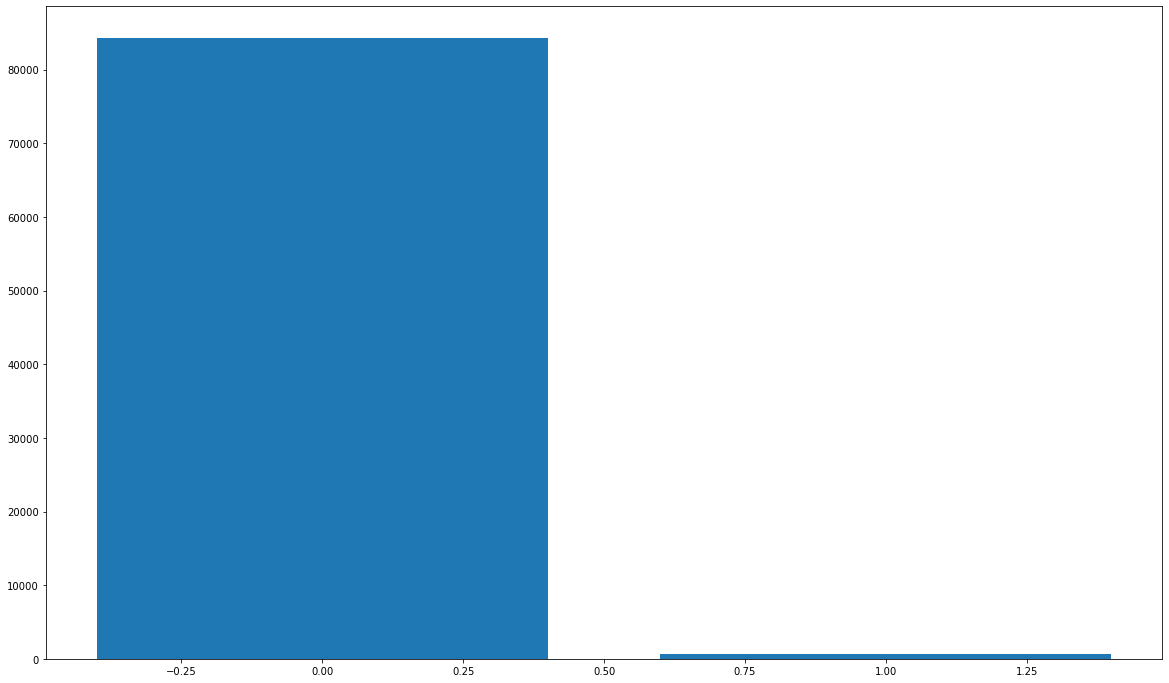

,publication_date,developer,views_num,dislikes_num,regulatory_impact,is_regionally_signigicant,act_changes_controlling_activities,mineco_solution
0,2013-09-11 00:00:00,ФСТ России,376.0,0.0,0,0,0,0
1,2013-06-11 00:00:00,Минтруд России,504.0,0.0,0,0,0,0
2,2013-04-29 00:00:00,Росфинмониторинг,428.0,0.0,0,0,0,0
3,2013-10-21 00:00:00,Минобрнауки России,376.0,0.0,0,0,0,0
4,2014-02-24 00:00:00,Минприроды России,499.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...
85001,2021-09-10 00:00:00,Минфин России,24.0,0.0,0,0,0,0
85002,2021-09-10 00:00:00,Роспотребнадзор,40.0,0.0,0,0,0,0
85003,2021-09-10 00:00:00,Единый государственный заказчик в сфере строит...,11.0,0.0,0,0,0,0
85004,2021-09-10 00:00:00,Минэнерго России,13.0,0.0,0,0,0,0


In [181]:
plt.figure(figsize=(20, 12))
plt.bar(*np.unique(df1['is_regionally_signigicant'], return_counts=True))
plt.show()
# df1.loc[:,['is_regionally_signigicant']] = [1 if i == True else 0 for i in df1['is_regionally_signigicant']]
# np.unique(df1['is_regionally_signigicant'], return_counts=True)
# df1['is_regionally_signigicant'].sum()
# df1['publication_date'].str.replace("nothing","").dt.strftime("%Y%m%d").astype(int)#.str.replace("nothing","").astype(int)#.str.replace("-","")#.astype(int)

df1

In [137]:
import re
import string
A = pd.DataFrame(df['act_title'])
A[0] = [x.split()[0].strip(string.punctuation).strip('«').lower() for x in A['act_title']]
display(pd.DataFrame(np.unique(A[0], return_counts=True)).transpose().sort_values(1, ascending=False).head(20))

def first_word(table, word):
    '''
        adding feature that the 1st word in act_title is equal to word
    '''
    table[word] = [1 if x.split()[0].strip(string.punctuation).strip('«').lower() == word else 0 
                   for x in table['act_title']]


A = pd.DataFrame(df['act_title'])
A[0] = [x.split()[0].strip(string.punctuation).strip('«').lower() for x in A['act_title']]
for word in pd.DataFrame(np.unique(A[0], return_counts=True)
                         ).transpose().sort_values(1, ascending=False)[0][:10].values:
    first_word(df, word)
first_word(df, 'о')
df['о'].sum()
sum(df['проект'])

,0,1
82,о,40816
83,об,31983
136,проект,6829
126,приказ,2017
203,федеральный,1190
16,административный,470
110,постановление,444
108,порядок,130
116,правила,87
188,указ,56


6829

In [135]:
pd.DataFrame(np.unique(A[0], return_counts=True)
                         ).transpose().sort_values(1, ascending=False)[0][:10].values

array(['о', 'об', 'проект', 'приказ', 'федеральный', 'административный',
       'постановление', 'порядок', 'правила', 'указ'], dtype=object)

In [156]:
len(X.columns)

123

 Lengths of Train and Test are: 81006 4000


,answer
count,81006.000000
mean,0.139558
std,0.346530
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,publication_date
count,4000
unique,1682
top,2018-04-19 00:00:00
freq,12


(array([69701.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 11305.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

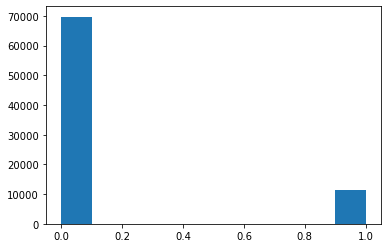

In [121]:
my_date = pd.DataFrame(df.copy().loc[:,['publication_date']])
Train = pd.DataFrame()
Train['publication_date'] = my_date[df1['id'].isin(answers['id'])]['publication_date']
Train['answer'] = list(answers['passed'])
#Train['publication_date'] = my_date[df1['id'].isin(answers['id'])]
Test = my_date[~df1['id'].isin(answers['id'])]
print(f' Lengths of Train and Test are: {len(Train)} {len(Test)}')
display(Train.describe(datetime_is_numeric=True))
display(Test.describe(datetime_is_numeric=True))

#Train = Train.dropna()

plt.hist(Train['answer'])

<AxesSubplot:>

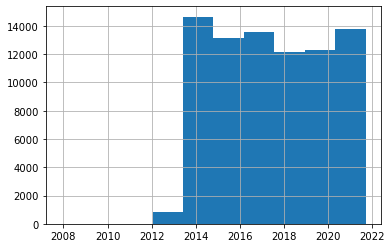

In [123]:
%matplotlib inline
Train['publication_date'] = [np.nan if x=='nothing' else x for x in Train['publication_date']]
Train = Train.dropna()
#Train['publication_date'].value_counts().plot.hist()
Train['publication_date'].hist()

<AxesSubplot:>

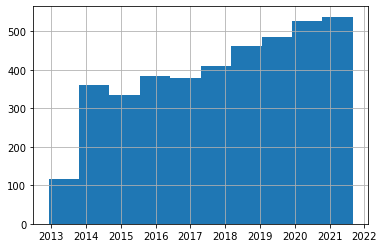

In [34]:
Test['publication_date'].hist()

In [127]:
Train['year'] = [0 if x=='nothing' else str(x.year) + "-" + str(x.month) for x in Train['publication_date']]
GT = Train.groupby('year').mean()
display(GT.iloc[-21:])
#Train['year'] = [x.year for x in Train['publication_date']]
Train['month'] = [np.nan if x.year in [2007, 2012, 2013, 2020, 2021] else x.month for x in Train['publication_date']]
Train = Train.dropna()
Train.groupby('month').mean()

,answer,month
year,,
2019-12,0.118182,12.0
2019-2,0.165975,2.0
2019-3,0.194743,3.0
2019-4,0.171642,4.0
2019-5,0.177814,5.0
2019-6,0.139410,6.0
2019-7,0.123835,7.0
2019-8,0.126374,8.0
2019-9,0.107673,9.0


,answer
month,
1.0,0.145809
2.0,0.159797
3.0,0.150168
4.0,0.149245
5.0,0.129587
6.0,0.156849
7.0,0.157378
8.0,0.142542
9.0,0.145197


,answer
year,
2020-1,0.162047
2020-10,0.108080
2020-11,0.083420
2020-12,0.097938
2020-2,0.166913
2020-3,0.151079
2020-4,0.154506
2020-5,0.124615
2020-6,0.138325


0        2013
1        2013
2        2013
3        2013
4        2014
         ... 
85001    2021
85002    2021
85003    2021
85004    2021
85005    2021
Name: month, Length: 85006, dtype: int64

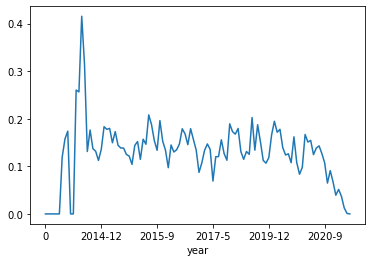

In [100]:
display(GT.iloc[-21:])
GT['answer'].plot()
df1['month']

In [24]:
df['publication_date'][0].year

2013

In [45]:
Train[Train['publication_date']=='nothing']

,publication_date,answer
16195,nothing,0
16226,nothing,0
16834,nothing,0
16885,nothing,0
16919,nothing,0
...,...,...
76807,nothing,0
76811,nothing,0
76819,nothing,0
77909,nothing,0


In [86]:
min(1,2)

1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


array([[<AxesSubplot:title={'center':'developer_Росгвардия'}>,
        <AxesSubplot:title={'center':'developer_Рослесхоз'}>,
        <AxesSubplot:title={'center':'developer_Минздрав России'}>,
        <AxesSubplot:title={'center':'developer_Минстрой России'}>,
        <AxesSubplot:title={'center':'developer_Минюст России'}>,
        <AxesSubplot:title={'center':'developer_ГФС России'}>,
        <AxesSubplot:title={'center':'developer_Роспечать'}>,
        <AxesSubplot:title={'center':'developer_Госкорпорация "Роскосмос"'}>],
       [<AxesSubplot:title={'center':'developer_Росграница'}>,
        <AxesSubplot:title={'center':'developer_Рособрнадзор'}>,
        <AxesSubplot:title={'center':'developer_Минпросвещения России'}>,
        <AxesSubplot:title={'center':'developer_Госкорпорация "Росатом"'}>,
        <AxesSubplot:title={'center':'developer_ФСС России'}>,
        <AxesSubplot:title={'center':'developer_Спецстрой России'}>,
        <AxesSubplot:title={'center':'developer_Пенсионный 

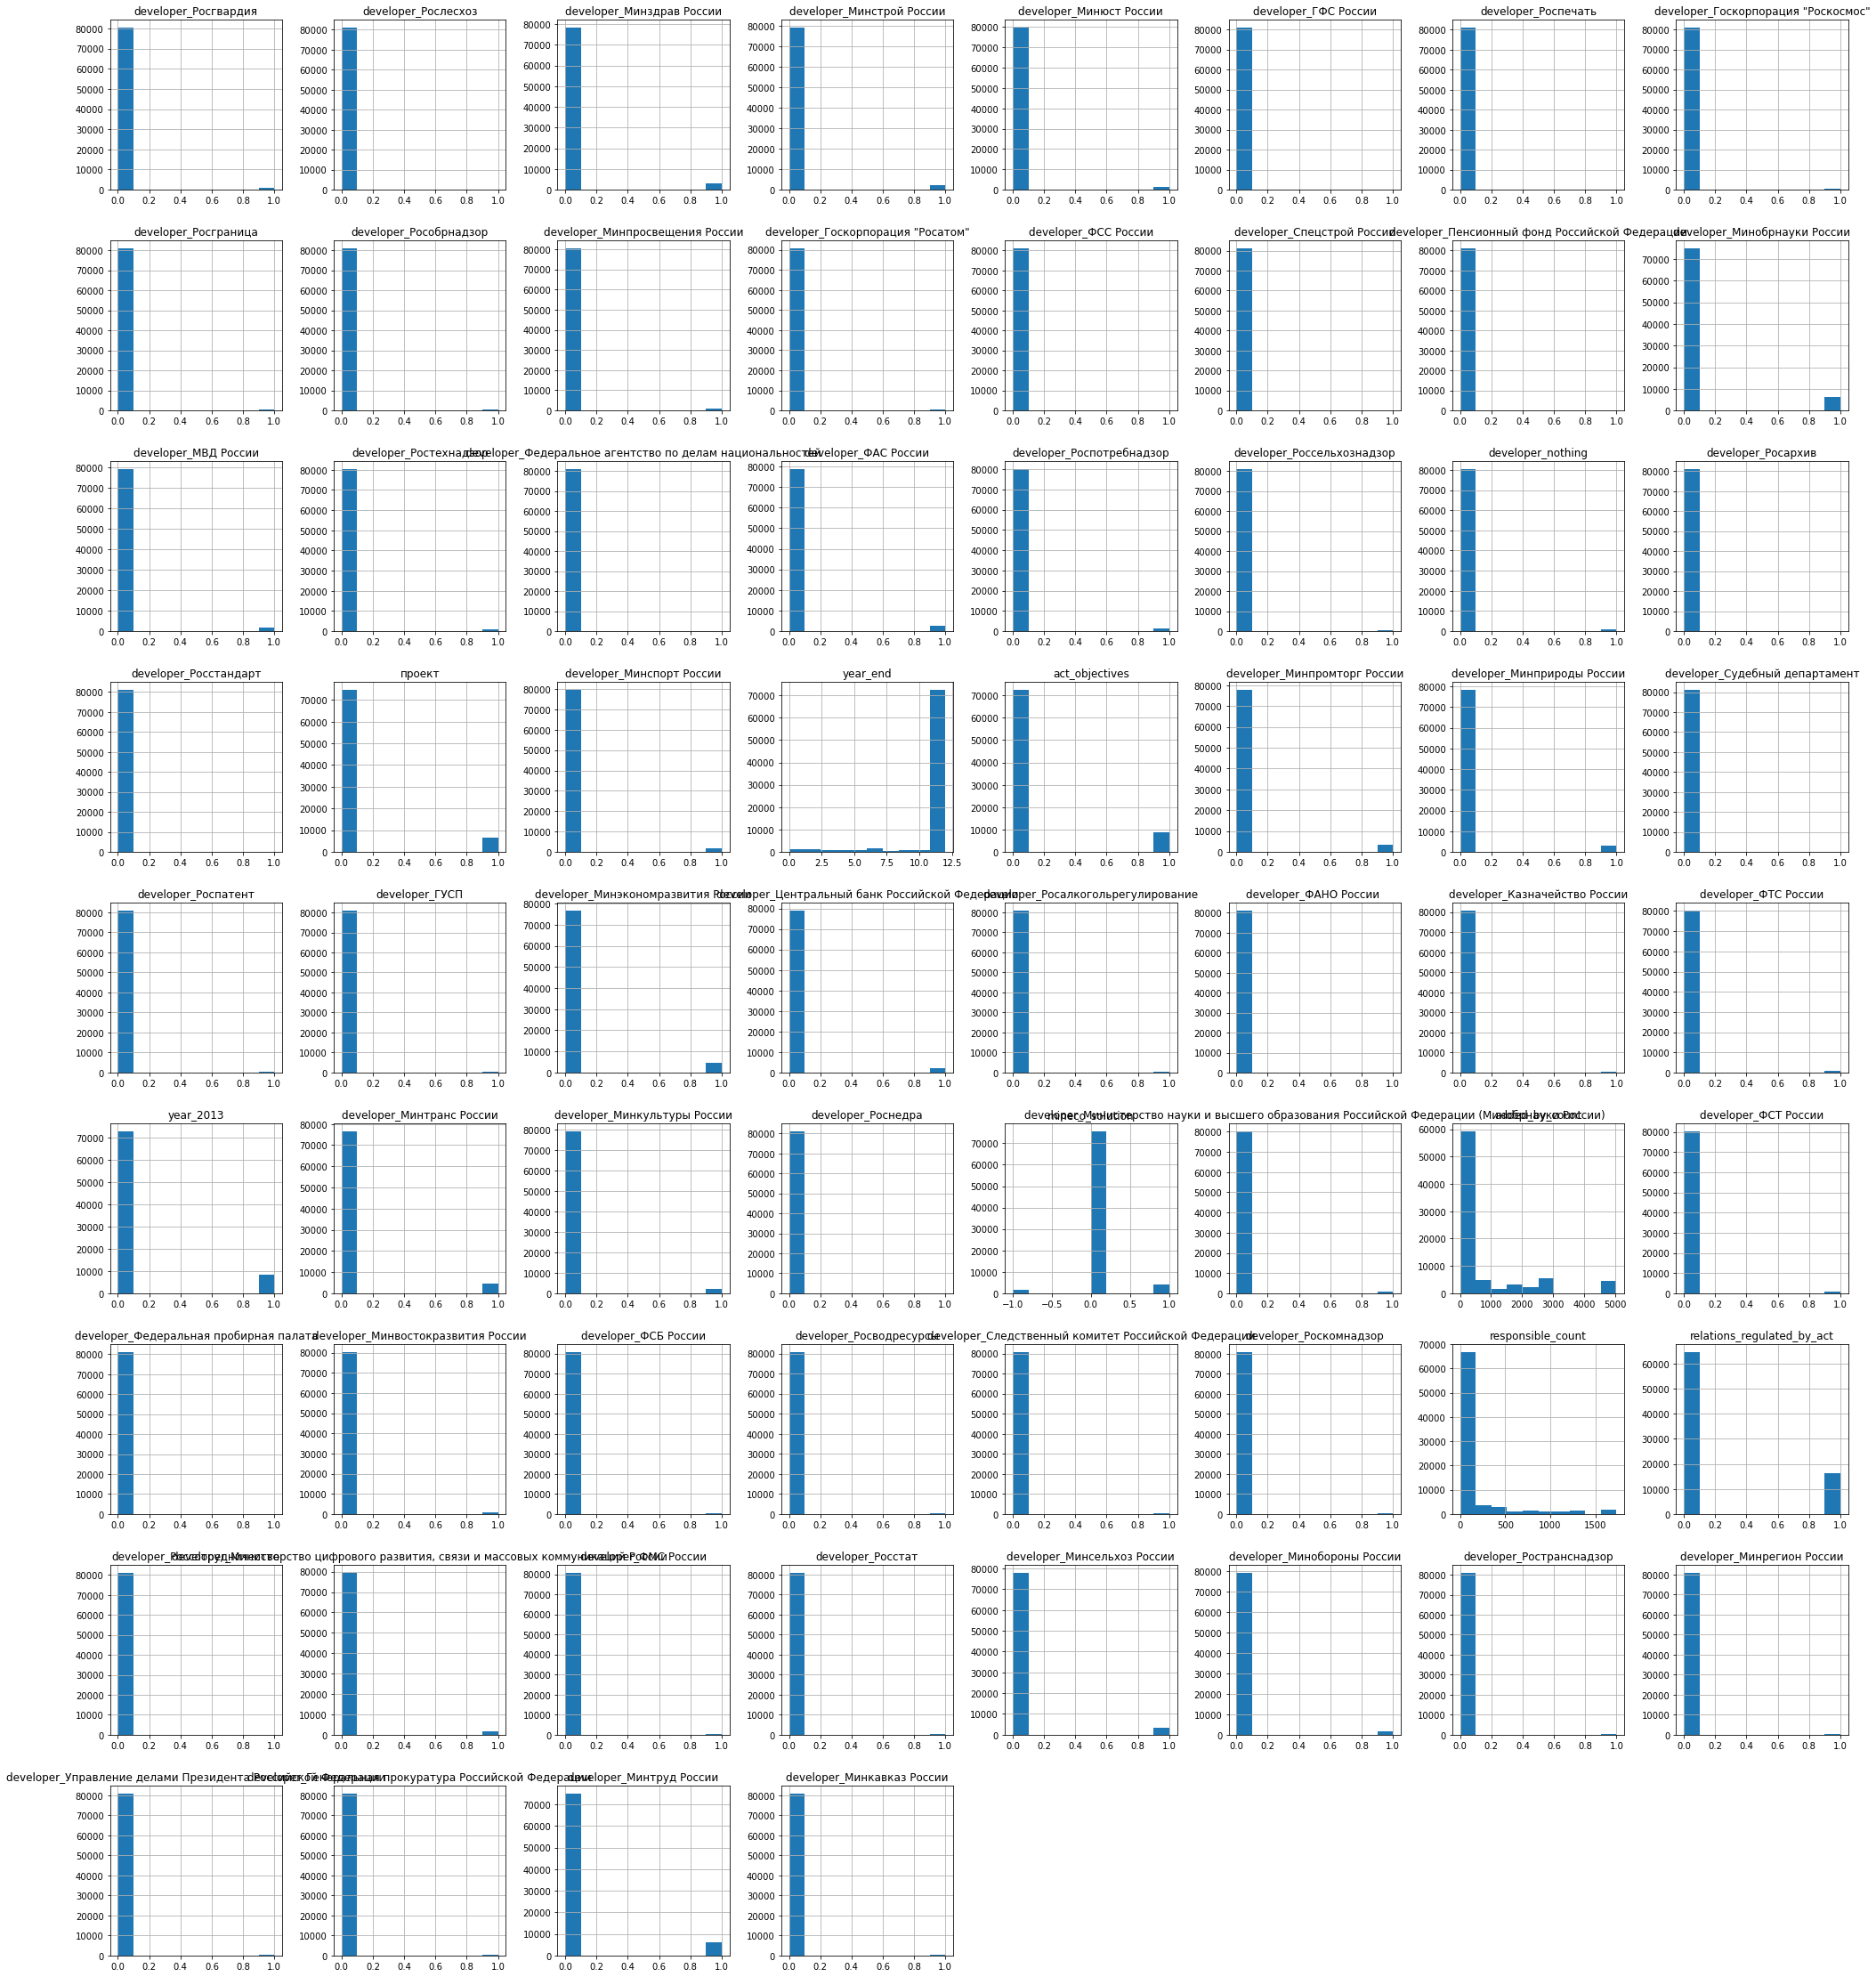

In [135]:
#pd.figure(figsize=(20, 12))

fig = plt.figure(figsize = (35,40))
ax = fig.gca()

X.hist(ax = ax)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


array([[<AxesSubplot:title={'center':'developer_Росгвардия'}>,
        <AxesSubplot:title={'center':'developer_Рослесхоз'}>,
        <AxesSubplot:title={'center':'developer_Минздрав России'}>,
        <AxesSubplot:title={'center':'developer_Минстрой России'}>,
        <AxesSubplot:title={'center':'developer_Минюст России'}>,
        <AxesSubplot:title={'center':'developer_ГФС России'}>,
        <AxesSubplot:title={'center':'developer_Роспечать'}>,
        <AxesSubplot:title={'center':'developer_Госкорпорация "Роскосмос"'}>],
       [<AxesSubplot:title={'center':'developer_Росграница'}>,
        <AxesSubplot:title={'center':'developer_Рособрнадзор'}>,
        <AxesSubplot:title={'center':'developer_Минпросвещения России'}>,
        <AxesSubplot:title={'center':'developer_Госкорпорация "Росатом"'}>,
        <AxesSubplot:title={'center':'developer_ФСС России'}>,
        <AxesSubplot:title={'center':'developer_Спецстрой России'}>,
        <AxesSubplot:title={'center':'developer_Пенсионный 

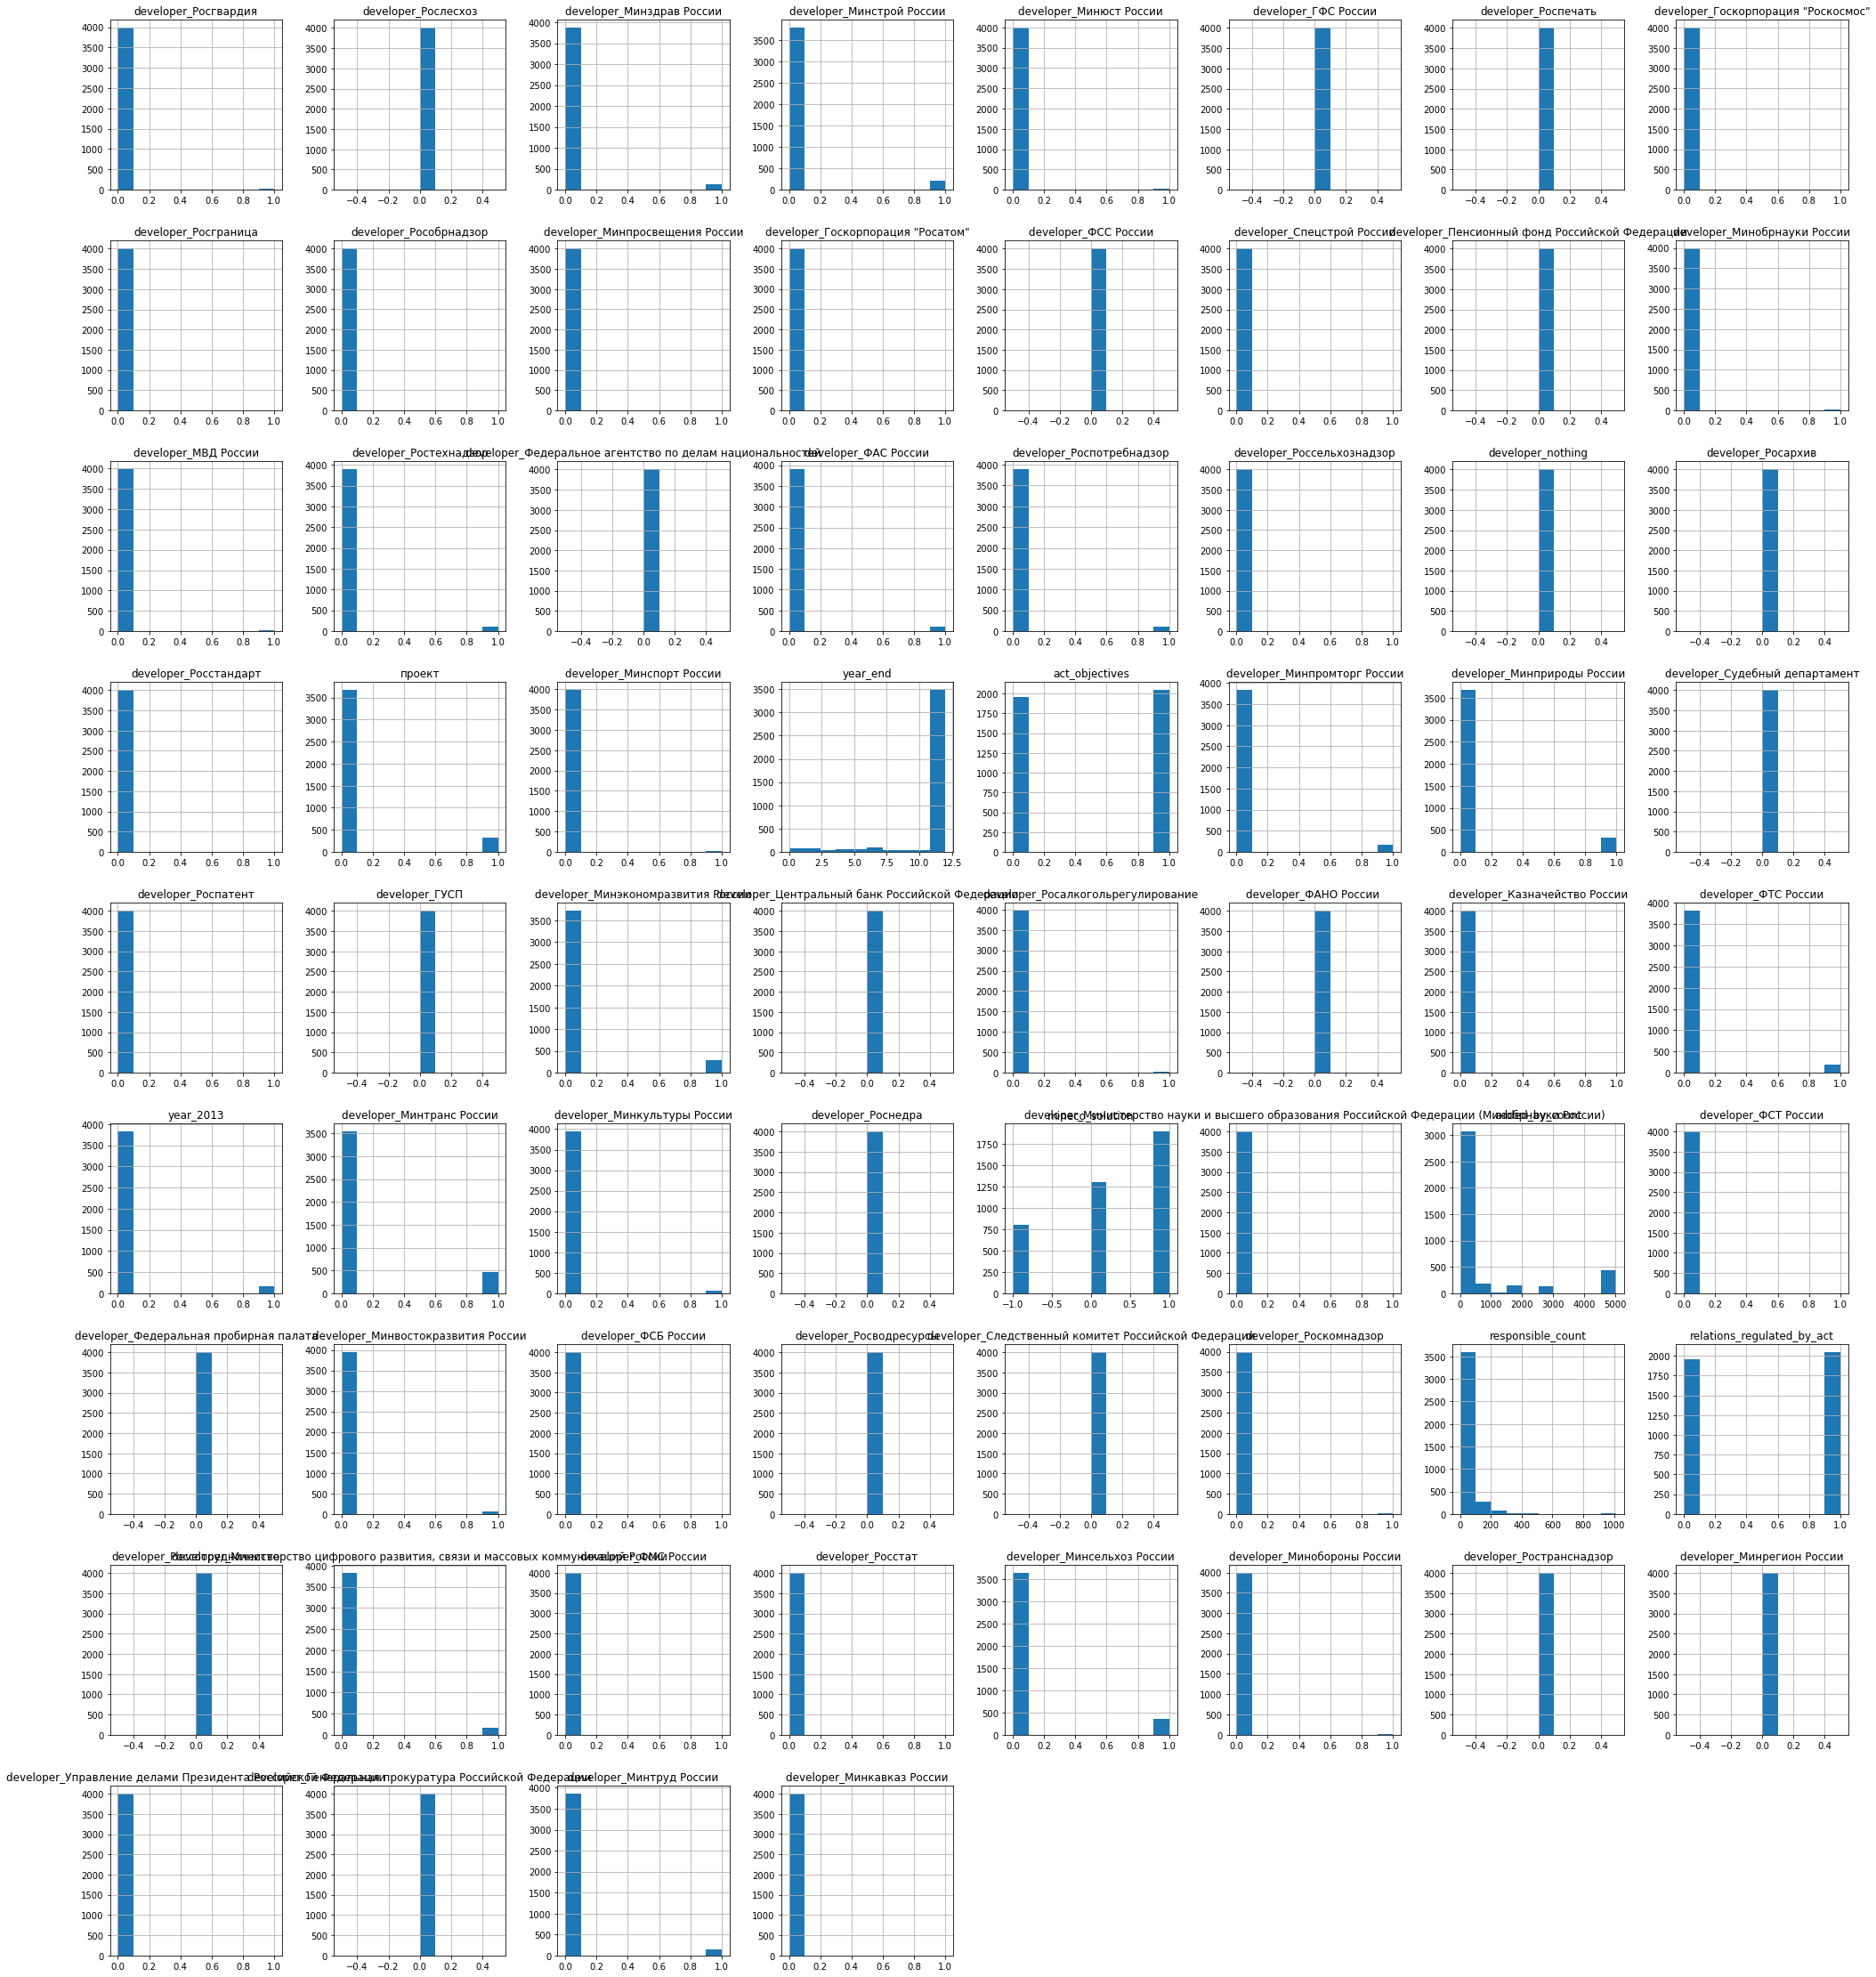

In [137]:
fig = plt.figure(figsize = (35,40))
ax = fig.gca()

X_res.hist(ax = ax)

In [142]:
df.isnull().sum()

id                                        0
act_title                                 1
publication_date                        589
developer                               785
okved_list                            11909
views_num                               589
comments_num                            589
likes_num                               589
dislikes_num                            589
regulatory_impact                       589
added_by                                589
responsible                            3322
is_regionally_signigicant               589
act_changes_controlling_activities      589
mineco_solution                         589
problem_addressed                     66505
act_objectives                        74325
persons_affected_by_act               66504
relations_regulated_by_act            66502
act_significance                      66505
dtype: int64

In [145]:
tr = df[df['id'].isin(answers['id'])]
tr.isnull().sum()/len(tr)

id                                    0.000000
act_title                             0.000012
publication_date                      0.007271
developer                             0.009691
okved_list                            0.142656
views_num                             0.007271
comments_num                          0.007271
likes_num                             0.007271
dislikes_num                          0.007271
regulatory_impact                     0.007271
added_by                              0.007271
responsible                           0.041009
is_regionally_signigicant             0.007271
act_changes_controlling_activities    0.007271
mineco_solution                       0.007271
problem_addressed                     0.796818
act_objectives                        0.893341
persons_affected_by_act               0.796818
relations_regulated_by_act            0.796793
act_significance                      0.796830
dtype: float64

In [146]:
te = df[~df['id'].isin(answers['id'])]
te.isnull().sum()/len(te)

id                                    0.00000
act_title                             0.00000
publication_date                      0.00000
developer                             0.00000
okved_list                            0.08825
views_num                             0.00000
comments_num                          0.00000
likes_num                             0.00000
dislikes_num                          0.00000
regulatory_impact                     0.00000
added_by                              0.00000
responsible                           0.00000
is_regionally_signigicant             0.00000
act_changes_controlling_activities    0.00000
mineco_solution                       0.00000
problem_addressed                     0.48950
act_objectives                        0.48975
persons_affected_by_act               0.48925
relations_regulated_by_act            0.48925
act_significance                      0.48925
dtype: float64